In [75]:
from collections import Counter
from copy import deepcopy
from dataclasses import dataclass
from functools import partial
from pprint import pprint
from typing import Any

import pandas as pd
import seaborn as sns
import yaml
from datasets import load_dataset

from juddges.prompts.information_extraction import SWISS_FRANC_LOAN_SCHEMA
from juddges.utils.misc import parse_yaml

sns.set_theme()

In [87]:
# ds = load_dataset("data/datasets/pl/sprawy_frankowe")
ds = load_dataset("data/datasets/pl/swiss_franc_loans")
ds

DatasetDict({
    train: Dataset({
        features: ['prompt', 'context', 'output'],
        num_rows: 4485
    })
    test: Dataset({
        features: ['prompt', 'context', 'output'],
        num_rows: 1139
    })
})

# Analyse #tokens

In [85]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")

In [89]:
def tokenize(item: dict[str, Any]) -> dict[str, Any]:
    return {"#output_tokens": tokenizer(item["output"], return_tensors="pt")["input_ids"].numel()}

ds = ds["train"].map(tokenize, batched=False, num_proc=4)

Map (num_proc=4):   0%|          | 0/4485 [00:00<?, ? examples/s]

[Text(0.5, 1.0, 'Number of tokens in output(min=452, max=692)')]

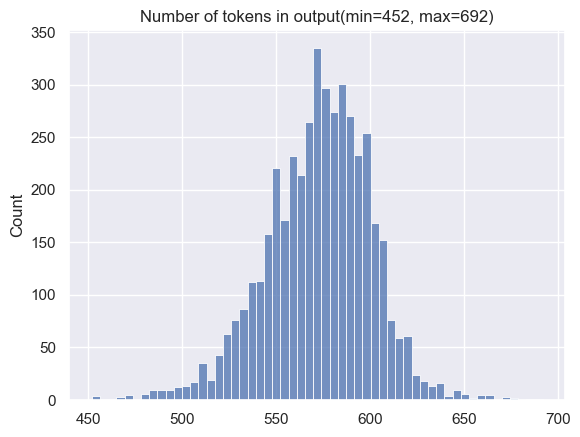

In [92]:
ax = sns.histplot(ds["#output_tokens"])
ax.set(title=f"Number of tokens in output(min={min(ds['#output_tokens'])}, max={max(ds['#output_tokens'])})")

# Analyse schema

In [77]:
_schema = {
    "apelacja": {
        "type": "string",
        "description": "Określenie apelacji, w której znajduje się sąd rozpoznający sprawę",
        "example": "Apelacja warszawska",
    },
    "typ_sadu": {
        "type": "enum",
        "choices": ["Sąd Rejonowy", "Sąd Okręgowy", "Sąd Frankowy", "Sąd Apelacyjny"],
        "description": "Typ sądu rozpoznającego sprawę",
        "example": "Sąd Rejonowy",
    },
    "instancja_sadu": {
        "type": "enum",
        "choices": ["Sąd I instancji", "Sąd odwoławczy"],
        "description": "Czy sąd jest I instancji czy odwoławczy",
        "example": "Sąd I instancji",
    },
    "podstawa_prawna": {
        "type": "string",
        "description": "Podstawa prawna roszczenia",
        "example": "Art. 385(1) Kodeksu cywilnego",
    },
    "podstawa_prawna_podana": {
        "type": "boolean",
        "description": "Czy powód podał podstawę prawną?",
        "example": True,
    },
    "rodzaj_roszczenia": {
        "type": "enum",
        "choices": [
            "O ustalenie istnienia/nieistnienia stosunku prawnego",
            "O ukształtowanie stosunku prawnego",
            "O zapłatę",
            "Roszczenia dodatkowe",
        ],
        "description": "Rodzaj roszczenia",
        "example": "O zapłatę",
    },
    "modyfikacje_powodztwa": {
        "type": "boolean",
        "description": "Czy były modyfikacje powództwa",
        "example": True,
    },
    "typ_modyfikacji": {
        "type": "enum",
        "choices": ["Rodzaj roszczenia", "Kwoty roszczenia"],
        "description": "Typ modyfikacji powództwa",
        "example": "Kwoty roszczenia",
    },
    "status_kredytobiorcy": {
        "type": "enum",
        "choices": ["Konsument", "Przedsiębiorca"],
        "description": "Status kredytobiorcy",
        "example": "Konsument",
    },
    "wspoluczestnictwo_powodowe": {
        "type": "boolean",
        "description": "Czy współuczestnictwo po stronie powodowej",
        "example": False,
    },
    "typ_wspoluczestnictwa": {
        "type": "enum",
        "choices": ["Małżeństwo", "Konkubinat", "Inni członkowie rodziny", "Spadkobiercy"],
        "description": "Rodzaj współuczestnictwa",
        "example": "Małżeństwo",
    },
    "rola_pozwanego": {
        "type": "enum",
        "choices": ["Strona umowy", "Następca prawny"],
        "description": "Czy pozwany faktycznie był stroną umowy czy następcą prawnym",
        "example": "Strona umowy",
    },
    "wczesniejsze_skargi_do_rzecznika": {
        "type": "boolean",
        "description": "Czy były uprzednie skargi do rzecznika finansowego",
        "example": False,
    },
    "umowa_kredytowa": {
        "type": "enum",
        "choices": ["Zawarta bezpośrednio w banku", "Z udziałem pośrednika"],
        "description": "Czy umowa kredytowa zawierana bezpośrednio w banku czy z pośrednikiem",
        "example": "Zawarta bezpośrednio w banku",
    },
    "klauzula_niedozwolona": {
        "type": "boolean",
        "description": "Istnienie klauzuli niedozwolonej w umowie",
        "example": True,
    },
    "wpisana_do_rejestru_uokik": {
        "type": "boolean",
        "description": "Czy klauzula wpisana do rejestru klauzul niedozwolonych UOKiK",
        "example": True,
    },
    "waluta_splaty": {
        "type": "enum",
        "choices": ["PLN", "CHF"],
        "description": "Waluta spłaty",
        "example": "CHF",
    },
    "aneks_do_umowy": {
        "type": "boolean",
        "description": "Czy był aneks do umowy",
        "example": True,
    },
    "data_aneksu": {
        "type": "date",
        "description": "Data aneksu",
        "example": "2023-01-15",
    },
    "przedmiot_aneksu": {
        "type": "enum",
        "choices": ["Zmiana waluty spłaty", "Inne kwestie"],
        "description": "Czego dotyczył aneks",
        "example": "Zmiana waluty spłaty",
    },
    "status_splaty_kredytu": {
        "type": "boolean",
        "description": "Czy kredyt był spłacony, w tym w trakcie procesu",
        "example": True,
    },
    "data_wyroku": {
        "type": "date",
        "description": "Data wydania wyroku",
        "example": "2024-11-30",
    },
    "rozstrzygniecie_sadu": {
        "type": "string",
        "description": "Rozstrzygnięcie",
        "example": "Oddalenie powództwa",
    },
    "typ_rozstrzygniecia": {
        "type": "enum",
        "choices": [
            "Uwzględnienie powództwa w całości",
            "Uwzględnienie powództwa w części",
            "Oddalenie powództwa",
            "Oddalenie apelacji",
            "Zmiana wyroku",
            "Przekazanie do ponownego rozpoznania",
        ],
        "description": "Typ rozstrzygnięcia",
        "example": "Oddalenie powództwa",
    },
    "sesja_sadowa": {
        "type": "enum",
        "choices": ["Rozprawa", "Posiedzenie niejawne"],
        "description": "Czy wyrok wydano na rozprawie czy na posiedzeniu niejawnym",
        "example": "Rozprawa",
    },
    "dowody": {
        "type": "list",
        "item_type": "enum",
        "choices": ["Przesłuchanie stron", "Przesłuchanie świadków", "Dowód z opinii biegłego"],
        "description": "Jakie dowody zostały przeprowadzone",
        "example": ["Przesłuchanie stron", "Dowód z opinii biegłego"],
    },
    "oswiadczenie_niewaznosci": {
        "type": "boolean",
        "description": "Czy odbierano oświadczenie powoda o skutkach nieważności umowy",
        "example": False,
    },
    "odwolanie_do_sn": {
        "type": "boolean",
        "description": "Czy odwołano się do orzecznictwa SN",
        "example": True,
    },
    "odwolanie_do_tsue": {
        "type": "boolean",
        "description": "Czy odwołano się do orzecznictwa TSUE",
        "example": True,
    },
    "teoria_prawna": {
        "type": "enum",
        "choices": ["Teoria dwóch kondykcji", "Teoria salda"],
        "description": "Teoria prawna, na której oparto wyrok",
        "example": "Teoria dwóch kondykcji",
    },
    "zarzut_zatrzymania_lub_potracenia": {
        "type": "boolean",
        "description": "Czy uwzględniono zarzut zatrzymania lub potrącenia",
        "example": False,
    },
    "odsetki_ustawowe": {
        "type": "boolean",
        "description": "Czy uwzględniono odsetki ustawowe",
        "example": True,
    },
    "data_rozpoczecia_odsetek": {
        "type": "enum",
        "choices": [
            "Od dnia wezwania do zapłaty",
            "Od daty wytoczenia powództwa",
            "Od daty wydania wyroku",
            "Od innej daty",
        ],
        "description": "Data rozpoczęcia naliczania odsetek",
        "example": "Od daty wydania wyroku",
    },
    "koszty_postepowania": {
        "type": "boolean",
        "description": "Czy zasądzono zwrot kosztów postępowania",
        "example": True,
    },
    "beneficjent_kosztow": {
        "type": "string",
        "description": "Na rzecz której strony zasądzono zwrot kosztów",
        "example": "Pozwany",
    },
    "zabezpieczenie_udzielone": {
        "type": "boolean",
        "description": "Czy udzielono zabezpieczenia",
        "example": True,
    },
    "rodzaj_zabezpieczenia": {
        "type": "string",
        "description": "Rodzaj zabezpieczenia",
        "example": "Wstrzymanie egzekucji",
    },
    "zabezpieczenie_pierwsza_instancja": {
        "type": "boolean",
        "description": "Czy zabezpieczenia udzielił sąd I instancji",
        "example": True,
    },
    "czas_trwania_sprawy": {
        "type": "string",
        "description": "Czas rozpoznania sprawy – od złożenia pozwu do wydania wyroku",
        "example": "2 lata 3 miesiące",
    },
    "wynik_sprawy": {
        "type": "enum",
        "choices": ["Wygrana kredytobiorcy", "Wygrana banku", "Częściowe uwzględnienie roszczeń obu stron"],
        "description": "Ocena, czy bank czy kredytobiorca wygrał sprawę",
        "example": "Wygrana kredytobiorcy",
    },
    "szczegoły_wyniku_sprawy": {
        "type": "string",
        "description": "Szczegóły dotyczące wyniku sprawy",
        "example": "Kredytobiorca wygrał, umowa uznana za nieważną",
    },
    "sprawa_frankowiczów": {
        "type": "boolean",
        "description": "Czy sprawa dotyczy kredytu frankowego (CHF)",
        "example": True,
    },
}

schema = deepcopy(_schema)
for name, data in schema.items():
    if data["type"] == "enum":
        data["choices"] = [item.strip().lower() for item in data["choices"]]
        
schema

{'apelacja': {'type': 'string',
  'description': 'Określenie apelacji, w której znajduje się sąd rozpoznający sprawę',
  'example': 'Apelacja warszawska'},
 'typ_sadu': {'type': 'enum',
  'choices': ['sąd rejonowy',
   'sąd okręgowy',
   'sąd frankowy',
   'sąd apelacyjny'],
  'description': 'Typ sądu rozpoznającego sprawę',
  'example': 'Sąd Rejonowy'},
 'instancja_sadu': {'type': 'enum',
  'choices': ['sąd i instancji', 'sąd odwoławczy'],
  'description': 'Czy sąd jest I instancji czy odwoławczy',
  'example': 'Sąd I instancji'},
 'podstawa_prawna': {'type': 'string',
  'description': 'Podstawa prawna roszczenia',
  'example': 'Art. 385(1) Kodeksu cywilnego'},
 'podstawa_prawna_podana': {'type': 'boolean',
  'description': 'Czy powód podał podstawę prawną?',
  'example': True},
 'rodzaj_roszczenia': {'type': 'enum',
  'choices': ['o ustalenie istnienia/nieistnienia stosunku prawnego',
   'o ukształtowanie stosunku prawnego',
   'o zapłatę',
   'roszczenia dodatkowe'],
  'description'

In [78]:
ds = ds["train"]

In [79]:
df = ds.to_pandas()
df.head()

,prompt,context,output
0,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt II C 845/10\n\nWYROK\nW IMIENIU RZEC...,```yaml\naneks_do_umowy: false\napelacja: ''\n...
1,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt V Ca 2194/11\n\nWYROK\nW IMIENIU RZE...,```yaml\naneks_do_umowy: false\napelacja: Apel...
2,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt I A Ca 1374/11\n\nWYROK\nW IMIENIU R...,```yaml\naneks_do_umowy: false\napelacja: Apel...
3,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt I C 494/11\n\nWYROK\nW IMIENIU RZECZ...,```yaml\naneks_do_umowy: false\napelacja: ''\n...
4,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt I ACa 720/11\n\nWYROK\nW IMIENIU RZE...,```yaml\naneks_do_umowy: false\napelacja: Apel...


In [80]:
outputs = df.join(pd.DataFrame(df["output"].apply(parse_yaml).tolist()))
outputs.head()

,prompt,context,output,aneks_do_umowy,apelacja,beneficjent_kosztow,czas_trwania_sprawy,data_aneksu,data_rozpoczecia_odsetek,data_wyroku,...,typ_wspoluczestnictwa,umowa_kredytowa,waluta_splaty,wczesniejsze_skargi_do_rzecznika,wpisana_do_rejestru_uokik,wspoluczestnictwo_powodowe,wynik_sprawy,zabezpieczenie_pierwsza_instancja,zabezpieczenie_udzielone,zarzut_zatrzymania_lub_potracenia
0,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt II C 845/10\n\nWYROK\nW IMIENIU RZEC...,```yaml\naneks_do_umowy: false\napelacja: ''\n...,False,,Pozwany,2 miesiące 28 dni,,,2010-12-21,...,,Zawarta bezpośrednio w banku,PLN,False,False,False,Wygrana banku,False,False,False
1,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt V Ca 2194/11\n\nWYROK\nW IMIENIU RZE...,```yaml\naneks_do_umowy: false\napelacja: Apel...,False,Apelacja warszawska,Powodowie,2 lata 5 miesięcy,,Od daty wytoczenia powództwa,2011-11-04,...,,Zawarta bezpośrednio w banku,PLN,False,False,False,Wygrana kredytobiorcy,False,False,False
2,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt I A Ca 1374/11\n\nWYROK\nW IMIENIU R...,```yaml\naneks_do_umowy: false\napelacja: Apel...,False,Apelacja wrocławska,Powód,9 miesięcy,,Od daty wytoczenia powództwa,2012-01-26,...,,Zawarta bezpośrednio w banku,CHF,False,False,False,Wygrana banku,False,False,False
3,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt I C 494/11\n\nWYROK\nW IMIENIU RZECZ...,```yaml\naneks_do_umowy: false\napelacja: ''\n...,False,,Powódka,3 miesiące,,Od daty wydania wyroku,2012-03-06,...,,Zawarta bezpośrednio w banku,PLN,False,True,False,Wygrana kredytobiorcy,False,False,False
4,"LANGUAGE = ""PL""\nJesteś asystentem odpowiedzia...",Sygn. akt I ACa 720/11\n\nWYROK\nW IMIENIU RZE...,```yaml\naneks_do_umowy: false\napelacja: Apel...,False,Apelacja białostocka,Pozwany,2 lata,,Od daty wytoczenia powództwa,2012-06-21,...,,Zawarta bezpośrednio w banku,CHF,False,False,False,Częściowe uwzględnienie roszczeń obu stron,False,False,False


# Validate data

In [82]:
from collections import defaultdict


def validate_yaml(yaml_str: str, schema: dict) -> dict[str, Any]:
    """
    Simple function to validate YAML against schema.
    Returns (is_valid, list_of_errors)
    """
    data = parse_yaml(yaml_str)

    if not isinstance(data, dict):
        return False, ["Data must be a dictionary"]

    errors = defaultdict(list)
    for field, field_schema in schema.items():
        if field not in data:
            errors["error_type"].append("missing")
            errors["field_name"].append(field)
            errors["field_type"].append(field_schema["type"])
            errors["field_schema"].append(field_schema)
            errors["value"].append(None)
            continue

        value = data[field]
        if value is None or value == "":
            continue

        field_type = field_schema["type"]

        if field_type == "enum" and value.strip().lower() not in field_schema["choices"]:
            errors["error_type"].append("bad_value")
            errors["field_name"].append(field)
            errors["field_type"].append(field_type)
            errors["field_schema"].append(field_schema)
            errors["value"].append(value)
        elif field_type == "date" and not isinstance(value, str):
            errors["error_type"].append("bad_value")
            errors["field_name"].append(field)
            errors["field_type"].append(field_type)
            errors["field_schema"].append(field_schema)
            errors["value"].append(value)
        elif field_type == "list" and not isinstance(value, list):
            errors["error_type"].append("bad_value")
            errors["field_name"].append(field)
            errors["field_type"].append(field_type)
            errors["field_schema"].append(field_schema)
            errors["value"].append(value)
            
    for field, value in data.items():
        if field not in schema:
            errors["error_type"].append("unknown_field")
            errors["field_name"].append(field)
            errors["field_type"].append(None)
            errors["field_schema"].append(None)
            errors["value"].append(value)

    errors["num_errors"] = len(errors["error_type"])
    return dict(errors)

In [83]:
errs = pd.DataFrame(df["output"].apply(partial(validate_yaml, schema=schema)).tolist())
errs.head()

,error_type,num_errors
0,[],0
1,[],0
2,[],0
3,[],0
4,[],0


<Axes: xlabel='num_errors', ylabel='count'>

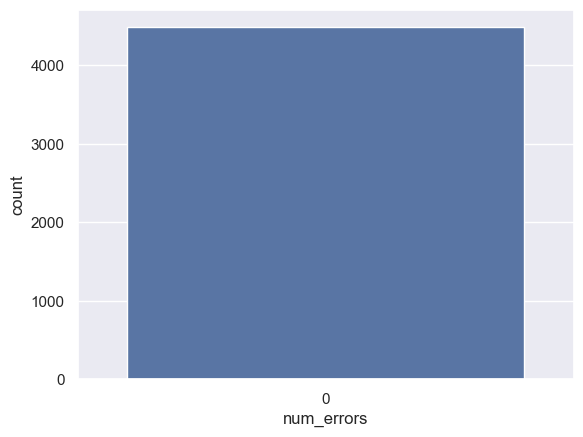

In [84]:
sns.countplot(data=errs, x="num_errors")

In [71]:
errs.explode("error_type").dropna()["error_type"].value_counts()

error_type
bad_value    454
Name: count, dtype: int64

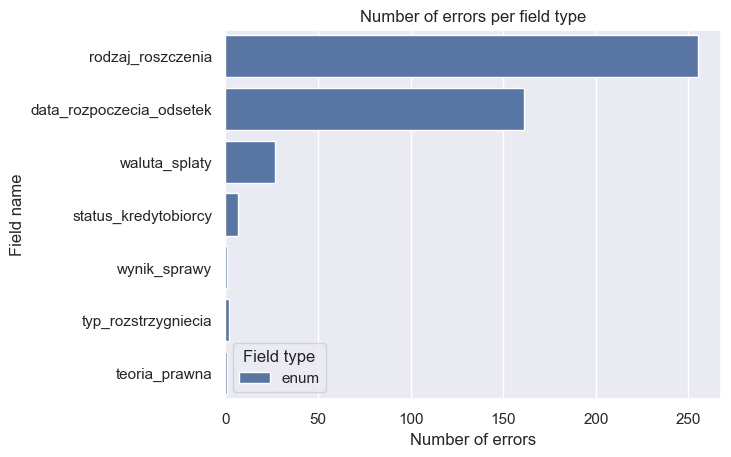

In [72]:
ax = sns.countplot(data=errs.explode(["field_type", "field_name"]).reset_index(drop=True), y="field_name", hue="field_type")
ax.set(title="Number of errors per field type")
ax.set_ylabel("Field name")
ax.set_xlabel("Number of errors")
ax.legend(title="Field type")

In [73]:
bad_val_stats = (
    errs.explode(["field_name", "value"])[["field_name", "value"]]
    .groupby(["field_name", "value"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)
)
with pd.option_context('display.max_rows', len(bad_val_stats), 'display.max_columns', None, 'display.width', None):
    display(bad_val_stats)

,field_name,value,size
52,rodzaj_roszczenia,O pozbawienie tytułu wykonawczego wykonalności,37
50,rodzaj_roszczenia,O podział majątku wspólnego,35
70,rodzaj_roszczenia,O uznanie istnienia/nieistnienia stosunku praw...,32
42,rodzaj_roszczenia,O obniżenie alimentów,29
10,data_rozpoczecia_odsetek,Od daty wniesienia pozwu,23
56,rodzaj_roszczenia,O pozbawienie wykonalności tytułu wykonawczego,23
81,waluta_splaty,EUR,21
47,rodzaj_roszczenia,O podwyższenie alimentów,21
40,rodzaj_roszczenia,O alimenty,18
34,data_rozpoczecia_odsetek,Od dnia uprawomocnienia się wyroku,18


In [74]:
for index, row in errs.explode("field_name").groupby("field_name").size().sort_values(ascending=False).reset_index().iterrows():
    print(f"========== {row['field_name']} (#errors = {row[0]:_}) ==========")
    pprint(schema[row["field_name"]])
    print()


========== rodzaj_roszczenia (#errors = 255) ==========
{'choices': ['o ustalenie istnienia/nieistnienia stosunku prawnego',
             'o ukształtowanie stosunku prawnego',
             'o zapłatę',
             'roszczenia dodatkowe'],
 'description': 'Rodzaj roszczenia',
 'example': 'O zapłatę',
 'type': 'enum'}

========== data_rozpoczecia_odsetek (#errors = 161) ==========
{'choices': ['od dnia wezwania do zapłaty',
             'od daty wytoczenia powództwa',
             'od daty wydania wyroku',
             'od innej daty'],
 'description': 'Data rozpoczęcia naliczania odsetek',
 'example': 'Od daty wydania wyroku',
 'type': 'enum'}

========== waluta_splaty (#errors = 27) ==========
{'choices': ['pln', 'chf'],
 'description': 'Waluta spłaty',
 'example': 'CHF',
 'type': 'enum'}

========== status_kredytobiorcy (#errors = 7) ==========
{'choices': ['konsument', 'przedsiębiorca'],
 'description': 'Status kredytobiorcy',
 'example': 'Konsument',
 'type': 'enum'}

========== ty